In [18]:
### Data Manipulation and Analysis
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Numerical operations and array handling

### Data Visualization
import matplotlib.pyplot as plt  # Data visualization and plotting

### Statistical Functions and Tests
from scipy.stats import linregress, t, kruskal, binomtest, boxcox  # Statistical functions and tests
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation and partial autocorrelation plots

### Machine Learning Metrics
from sklearn.metrics import mean_squared_error, make_scorer  # Machine learning metrics for model evaluation

### Time Series Analysis and Models
import statsmodels.api as sm  # Various statistical models and tests
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model for time series forecasting
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

### Machine Learning Models
from sklearn.neural_network import MLPRegressor  # Neural network models, specifically MLPRegressor

### Utility Functions
import itertools  # Utility functions for efficient looping
import warnings # Supress Warnings


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [19]:
# Function for the Cox-Stuart test
def cox_stuart_test(data):
    n = len(data)
    half = n // 2
    if n % 2 != 0:  # if the number of observations is odd, remove the last point to pair up
        half = (n - 1) // 2
    first_half = data[:half]
    second_half = data[-half:]
    diffs = np.sign(second_half - first_half)
    S = np.sum(diffs == -1)
    T = np.sum(diffs == 1)
    return S, T, half

# Function for inverse Box-Cox transformation
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)
    
# Function to evaluate SARIMA model
def evaluate_sarima_model(train, test, arima_order, seasonal_order, lmbda, seed):
    np.random.seed(seed)  # Set the random seed for reproducibility
    model = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    predictions_inv = inv_boxcox(predictions, lmbda)
    test_inv = inv_boxcox(test, lmbda)
    rmse = np.sqrt(mean_squared_error(test_inv, predictions_inv))
    aic = model_fit.aic
    return rmse, aic

# Create function to prepare the dataset for MLP
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Define the evaluation metric (RMSE)
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [20]:
# Read the DataFrame from the CSV file
df_total = pd.read_csv('../data/month_energy_dataset.csv')

# Create a date column by combining year and month
df_total['date'] = pd.to_datetime(df_total[['year', 'month']].assign(day=1))

# Set the date column as the index
df_total.set_index('date', inplace=True)

# Filter the DataFrame for the desired date range
df_total = df_total.loc['2007-01':'2024-06']

# Convert the generation values to thousands
df_total['generation_value'] = df_total['val_geracao'] / 1000

df_total

,year,month,val_geracao,generation_value
date,,,,
2007-01-01,2007,1,44518.780,44.518780
2007-02-01,2007,2,36306.070,36.306070
2007-03-01,2007,3,28729.610,28.729610
2007-04-01,2007,4,37405.240,37.405240
2007-05-01,2007,5,39726.350,39.726350
...,...,...,...,...
2024-02-01,2024,2,6339384.520,6339.384520
2024-03-01,2024,3,5302217.979,5302.217979
2024-04-01,2024,4,6003793.409,6003.793409


In [21]:
# Train Dataset
df_train = df_total.loc['2007-01':'2021-12']

# Test Dataset
df_test = df_total.loc['2022-01':'2023-03']

# Validation Dataset
df_validation = df_total.loc['2023-04':'2024-06']

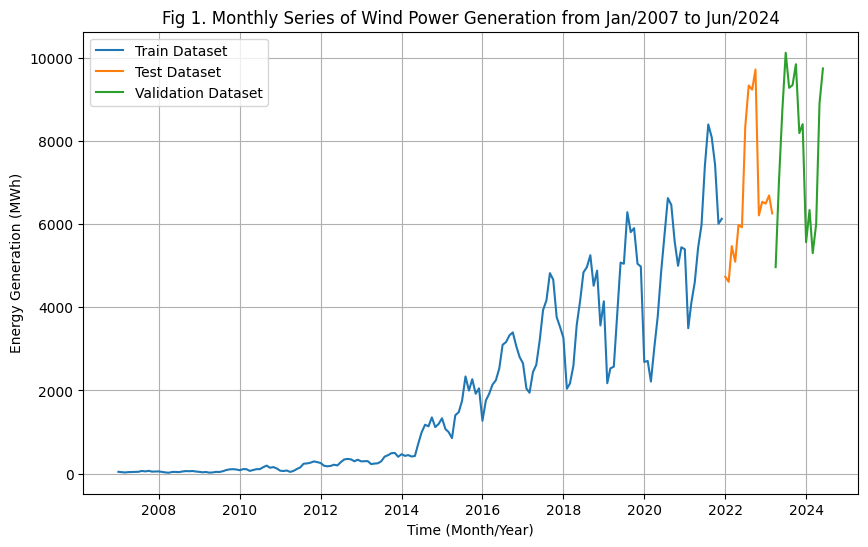

In [28]:
# Plot the training, test and validation sets
plt.figure(figsize=(10, 6))

plt.plot(df_train['generation_value'], label='Train Dataset')
plt.plot(df_test['generation_value'], label='Test Dataset')
plt.plot(df_validation['generation_value'], label='Validation Dataset')

plt.title('Fig 1. Monthly Series of Wind Power Generation from Jan/2007 to Jun/2024')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

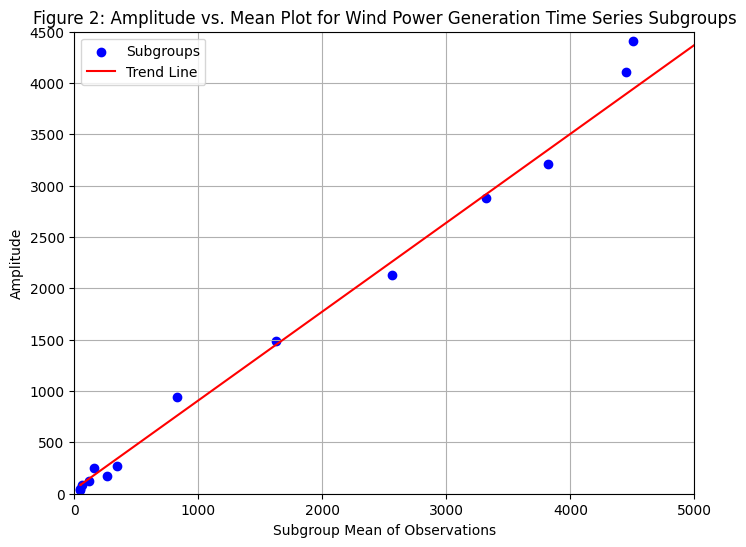

Slope:  0.8653655724818611
P-value: 4.3076653355456074e-14


In [23]:
# Divide the time series into subgroups of size N (e.g., 12 months)
N = 12  # Subgroup size (e.g., 12 for annual subgroups)
subgroups = [df_train['generation_value'][i:i + N] for i in range(0, len(df_train), N)]

# Calculate the mean and amplitude for each subgroup
mean_values = [group.mean() for group in subgroups if len(group) == N]
amplitude_values = [group.max() - group.min() for group in subgroups if len(group) == N]

# Linear regression for the trend line
slope, intercept, r_value, p_value, std_err = linregress(mean_values, amplitude_values)
line = [slope * xi + intercept for xi in mean_values]

# Plot the amplitude versus mean graph
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, amplitude_values, color='blue', label='Subgroups')
plt.plot(mean_values, line, color='red', label='Trend Line')

# Add titles and labels
plt.title('Figure 2: Amplitude vs. Mean Plot for Wind Power Generation Time Series Subgroups')
plt.xlabel('Subgroup Mean of Observations')
plt.ylabel('Amplitude')

# Adjust axis limits to match the original graph
plt.xlim(0, 5000)
plt.ylim(0, 4500)

# Add grid
plt.grid(True)

# Show legend
plt.legend()

# Display the graph
plt.show()

# Calculate the t-value and the associated p-value
t_value = slope / std_err
d_f = len(mean_values) - 2  # degrees of freedom
p_value = 2 * (1 - t.cdf(np.abs(t_value), d_f))

print('Slope: ', slope)
print(f'P-value: {p_value}')


Estimated lambda value: 0.0946725485940968


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_21084\2818847917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['generation_value_boxcox'], fitted_lambda = boxcox(df_train['generation_value'])


<Figure size 1000x600 with 0 Axes>

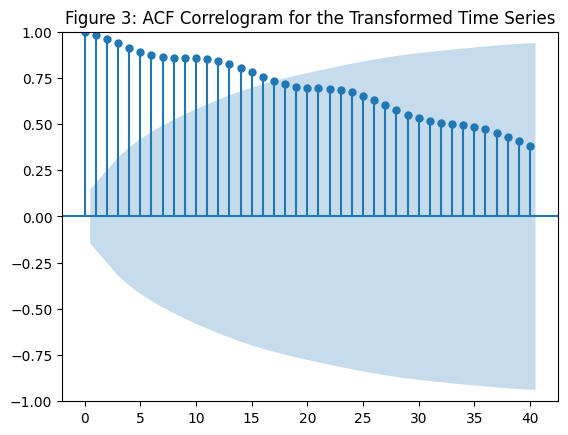

<Figure size 1000x600 with 0 Axes>

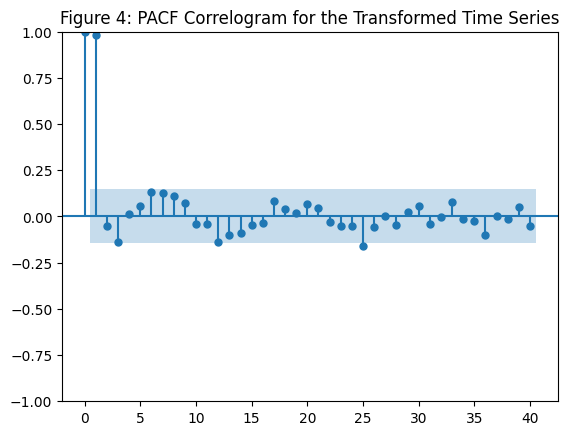

In [24]:
# Apply Box-Cox transformation
df_train['generation_value_boxcox'], fitted_lambda = boxcox(df_train['generation_value'])
print(f'Estimated lambda value: {fitted_lambda}')

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df_train['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 3: ACF Correlogram for the Transformed Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df_train['generation_value_boxcox'], lags=40, alpha=0.05)
plt.title('Figure 4: PACF Correlogram for the Transformed Time Series')
plt.show()

In [25]:
# Cox-Stuart test for trend
S, T, half = cox_stuart_test(df_train['generation_value_boxcox'])
p_value_cox_stuart = binomtest(min(S, T), n=half, p=0.5).pvalue  # Binomial test to calculate the p-value
print(f'Cox-Stuart Test: S={S}, T={T}, p-value={p_value_cox_stuart}')

Cox-Stuart Test: S=0, T=0, p-value=1.6155871338926322e-27


In [26]:
df_train

,year,month,val_geracao,generation_value,generation_value_boxcox
date,,,,,
2007-01-01,2007,1,4.451878e+04,44.518780,4.567582
2007-02-01,2007,2,3.630607e+04,36.306070,4.278275
2007-03-01,2007,3,2.872961e+04,28.729610,3.953034
2007-04-01,2007,4,3.740524e+04,37.405240,4.320241
2007-05-01,2007,5,3.972635e+04,39.726350,4.405311
...,...,...,...,...,...
2021-08-01,2021,8,8.399121e+06,8399.121369,14.285374
2021-09-01,2021,9,8.087443e+06,8087.442578,14.196577
2021-10-01,2021,10,7.435701e+06,7435.701346,14.000414


In [16]:
# Kruskal-Wallis test for seasonality
# Group data by month to check for seasonality
df_train['month'] = df_train.index.month
seasonal_groups = [df_train[df_train['month'] == month]['generation_value_boxcox'] for month in range(1, 13)]
H, p_value_kruskal = kruskal(*seasonal_groups)
print(f'Kruskal-Wallis Test: H={H}, p-value={p_value_kruskal}')

Kruskal-Wallis Test: H=8.564297114794272, p-value=0.662039319841367


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_21084\2531897529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'] = df_train.index.month


C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_21084\2881616414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['generation_value_boxcox_diff'] = df_train['generation_value_boxcox'].diff().dropna()


<Figure size 1000x600 with 0 Axes>

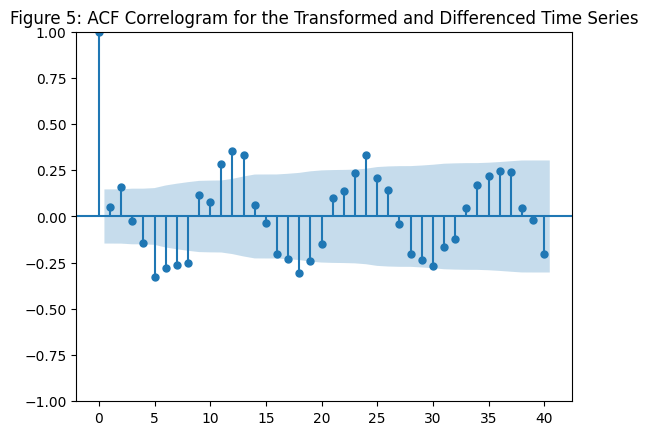

<Figure size 1000x600 with 0 Axes>

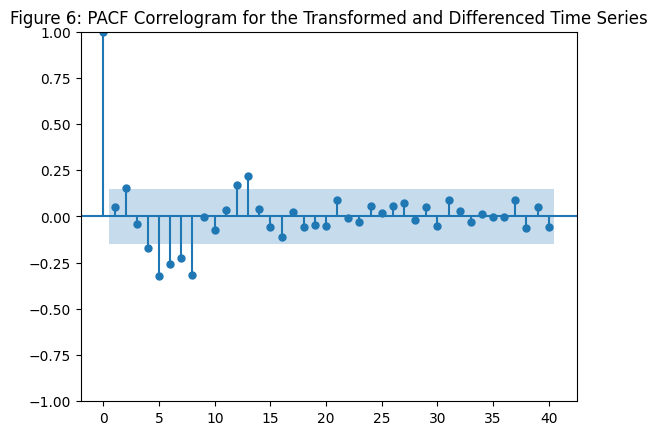

In [27]:
# Apply first-order differencing
df_train['generation_value_boxcox_diff'] = df_train['generation_value_boxcox'].diff().dropna()

# Remove N/A values
df = df_train.dropna(subset=['generation_value_boxcox_diff'])

# ACF Correlogram
plt.figure(figsize=(10, 6))
plot_acf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 5: ACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

# PACF Correlogram
plt.figure(figsize=(10, 6))
plot_pacf(df['generation_value_boxcox_diff'], lags=40, alpha=0.05)
plt.title('Figure 6: PACF Correlogram for the Transformed and Differenced Time Series')
plt.show()

## SARIMA Model

In [35]:
# Parameters
p_values = [2, 4, 5, 6, 7, 8]
d_values = [0, 1]
q_values = [2, 4, 5, 6, 7, 8]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [1, 2, 3]
S = 12  # Seasonal order
seed = 42  # Random seed for reproducibility

# Apply Box-Cox transformation to the test dataset
df_test['generation_value_boxcox'] = boxcox(df_test['generation_value'], fitted_lambda)

# Split the data into train and test sets
train = df_train
test = df_test

# Store results
results = []

# Suppress specific warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

# Generate all combinations of (p,d,q) and run SARIMA models
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    if q == S:  # Avoid overlap of seasonal and non-seasonal lags
        continue
    arima_order = (p, d, q)
    seasonal_order = (P, D, Q, S)
    print(f'Generating model with ARIMA order {arima_order} and seasonal order {seasonal_order}')
    try:
        rmse, aic = evaluate_sarima_model(train['generation_value_boxcox'], test['generation_value_boxcox'], arima_order, seasonal_order, fitted_lambda, seed)
        results.append((arima_order, seasonal_order, rmse, aic))
    except Exception as e:
        results.append((arima_order, seasonal_order, None, None))
        print(f'Error with ARIMA order {arima_order} and seasonal order {seasonal_order}: {e}')

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['ARIMA Order', 'Seasonal Order', 'RMSE', 'AIC'])
results_df = results_df.sort_values(by='RMSE').dropna()

# Display the best models
results_df.head()

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_21084\4026691783.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['generation_value_boxcox'] = boxcox(df_test['generation_value'], fitted_lambda)


Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 0, 1, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 0, 2, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 0, 3, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 1, 1, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 1, 2, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (0, 1, 3, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 0, 1, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 0, 2, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 0, 3, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 1, 1, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 1, 2, 12)
Generating model with ARIMA order (2, 0, 2) and seasonal order (1, 1, 3, 12)
Generating model with ARIMA order (2, 0, 4) and seasonal order (0, 0, 1, 12)

e:\Anaconda\envs\energy_env_310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Error with ARIMA order (4, 0, 2) and seasonal order (1, 0, 1, 12): Input contains NaN.
Generating model with ARIMA order (4, 0, 2) and seasonal order (1, 0, 2, 12)


e:\Anaconda\envs\energy_env_310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Error with ARIMA order (4, 0, 2) and seasonal order (1, 0, 2, 12): Input contains NaN.
Generating model with ARIMA order (4, 0, 2) and seasonal order (1, 0, 3, 12)


e:\Anaconda\envs\energy_env_310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Error with ARIMA order (4, 0, 2) and seasonal order (1, 0, 3, 12): Input contains NaN.
Generating model with ARIMA order (4, 0, 2) and seasonal order (1, 1, 1, 12)
Generating model with ARIMA order (4, 0, 2) and seasonal order (1, 1, 2, 12)
Generating model with ARIMA order (4, 0, 2) and seasonal order (1, 1, 3, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 0, 1, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 0, 2, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 0, 3, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 1, 1, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 1, 2, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (0, 1, 3, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (1, 0, 1, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (1, 0, 2, 12)
Generating model with ARIMA order (4, 0, 4) and seasonal order (1,

,ARIMA Order,Seasonal Order,RMSE,AIC
198,"(4, 0, 7)","(1, 0, 1, 12)",779.046395,134.955451
594,"(7, 0, 4)","(1, 0, 1, 12)",780.794348,138.091258
739,"(8, 0, 4)","(1, 0, 2, 12)",781.741663,132.843314
476,"(6, 0, 6)","(1, 0, 3, 12)",782.844063,114.491491
174,"(4, 0, 5)","(1, 0, 1, 12)",783.464054,133.155432


In [36]:
SARIMA_RMSE_ARTICLE = 773.79

In [113]:
# Fit the chosen SARIMA model
arima_order = (4, 0, 7)
seasonal_order = (1, 0, 1, 12)
model = SARIMAX(train['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(test)  # Number of steps for forecasting
predictions = model_fit.forecast(steps=steps)
predictions_inv = inv_boxcox(predictions, fitted_lambda)

SARIMA_pred_test = predictions_inv

In [39]:
rmse_scorer(test['generation_value'], predictions_inv)

779.0463951933634

In [87]:
model_resid = model_fit.resid

In [41]:
pred_resid = test['generation_value'] - predictions_inv

pred_resid

date
2022-01-01    -862.313020
2022-02-01     -95.637459
2022-03-01     672.829585
2022-04-01    -250.015846
2022-05-01    -226.227038
2022-06-01   -1225.386884
2022-07-01     317.201813
2022-08-01     454.514650
2022-09-01     428.076299
2022-10-01    1277.583291
2022-11-01   -1493.713925
2022-12-01   -1111.864808
2023-01-01    -599.913235
2023-02-01     575.719869
2023-03-01     -39.584317
dtype: float64

Prediction for validation Dataset

In [48]:
# Concatenate the train and test datasets
df_train_valid = pd.concat([df_train[['generation_value_boxcox']], df_test[['generation_value_boxcox']]])

# Ensure the index is sorted
df_train_valid = df_train_valid.sort_index()

df_train_valid

,generation_value_boxcox
date,
2007-01-01,4.567582
2007-02-01,4.278275
2007-03-01,3.953034
2007-04-01,4.320241
2007-05-01,4.405311
...,...
2022-11-01,13.585480
2022-12-01,13.703136
2023-01-01,13.687778


RMSE: 1305.3830206965106


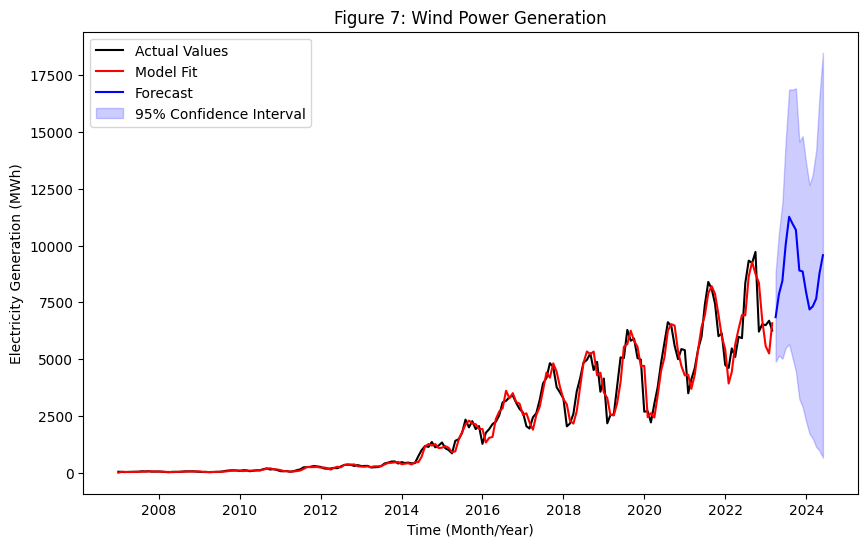

<Figure size 1000x600 with 0 Axes>

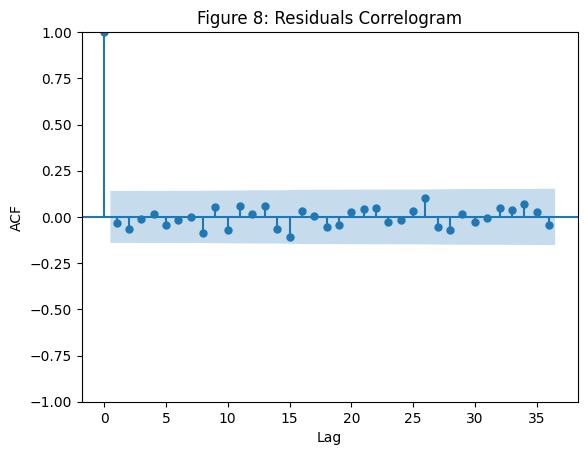

In [108]:
# Fit the chosen SARIMA model
arima_order = (4, 0, 4)
seasonal_order = (1, 0, 2, 12)

model = SARIMAX(df_train_valid['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecasting
steps = len(df_validation)  # Number of steps for forecasting based on test dataset length
predictions_future = model_fit.forecast(steps=steps)
predictions_future_inv = inv_boxcox(predictions_future, fitted_lambda)
df_inv = inv_boxcox(df_train_valid['generation_value_boxcox'], fitted_lambda)

# Obtain forecasts with confidence intervals
forecast_results = model_fit.get_forecast(steps=steps)
conf_int = forecast_results.conf_int(alpha=0.05)

# Convert the lower and upper bounds back from Box-Cox
conf_int_inv = inv_boxcox(conf_int, fitted_lambda)

# Calculating standard deviations
std_errors = (conf_int_inv.iloc[:, 1] - conf_int_inv.iloc[:, 0]) / (2 * 1.96)

# Generate dates for the forecast period from 2023-04 to 2024-06
last_date = df_train_valid.index[-1]
dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]

# Convert predictions_future_inv to DataFrame
predictions_future_inv = predictions_future_inv.to_frame(name='Forecast')

# Ensure std_errors is in a DataFrame
std_errors_df = pd.DataFrame(std_errors, index=predictions_future_inv.index, columns=['std_err'])

# Build the forecast_df DataFrame with forecasts and standard errors
forecast_df = pd.concat([predictions_future_inv, std_errors_df], axis=1)

# Calculating the 95% confidence interval
lower_bound = forecast_df['Forecast'] - 1.96 * forecast_df['std_err']
upper_bound = forecast_df['Forecast'] + 1.96 * forecast_df['std_err']

# Calculate RMSE for the validation set
validation_actuals = df_validation['generation_value']
SARIMA_RMSE = np.sqrt(np.mean((validation_actuals - predictions_future_inv.squeeze())**2))
print(f'RMSE: {rmse}')

# Calculate the resid

SARIMA_resid = model_fit.resid

SARIMA_pred = predictions_future_inv

# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_train_valid.index, df_inv, color='black', label='Actual Values')
plt.plot(df_train_valid.index, inv_boxcox(model_fit.fittedvalues, fitted_lambda), color='red', label='Model Fit')
plt.plot(predictions_future_inv.index, predictions_future_inv, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

# Correlogram of the residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=36)
plt.title('Figure 8: Residuals Correlogram')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# MLP Model

In [64]:
# Concatenate the train and test datasets
df_train_MLP = pd.concat([df_train[['generation_value']], df_test[['generation_value']]])

# Ensure the index is sorted
df_train_MLP = df_train_MLP.sort_index()

# Prepare the data for training
values_mlp = df_train_MLP['generation_value'].values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values_mlp, look_back)

# Split the data into training and testing sets
train_end_index = df_train_MLP.index.get_loc('2022-01-01')
test_start_index = df_train_MLP.index.get_loc('2022-01-01')

trainX, testX = X[:train_end_index - look_back], X[train_end_index - look_back:test_start_index + len(df_train_MLP.loc['2022-01':'2023-03'])]
trainY, testY = y[:train_end_index - look_back], y[train_end_index - look_back:test_start_index + len(df_train_MLP.loc['2022-01':'2023-03'])]

In [73]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score: -417.1515677817964


In [75]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}
Best score (RMSE on original scale): -417.1515677817964


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
2,"(100, 100)",0.0001,adam,relu,417.151568,277.804869
4,"(150, 150)",0.0001,adam,relu,418.626769,292.981539
16,"(150, 150)",0.01,adam,relu,420.871477,297.559008
10,"(150, 150)",0.001,adam,relu,429.542231,304.478190
22,"(150, 150)",0.1,adam,relu,429.972357,302.386390


In [78]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

# Calculate RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
testScore = np.sqrt(mean_squared_error(testY, testPredict))

print(f'Train RMSE: {trainScore}')
print(f'Test RMSE: {testScore}')

Train RMSE: 117.56603046230401
Test RMSE: 1185.6237996696477


RMSE for MLP model: 2691.6310580429445


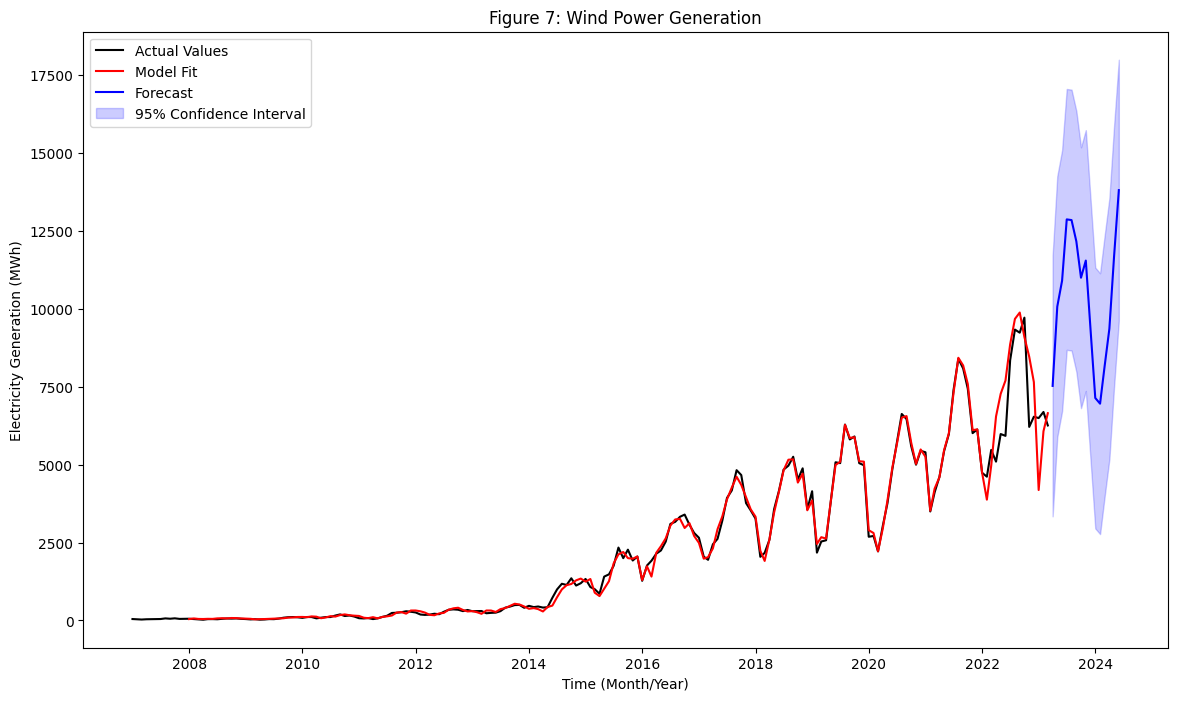

In [84]:
# Make future predictions from April 2023 to June 2024
future_steps = 15  # Number of months from April 2023 to June 2024
last_window = values_mlp[-look_back:].reshape(1, -1)

future_predictions = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions = np.array(future_predictions).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2023-04-01', periods=future_steps, freq='MS')
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['generation_value'])

# Calculate confidence intervals
prediction_intervals = []
std_future = np.std(future_predictions)
for pred in future_predictions:
    lower_bound = pred - 1.96 * std_future  # 95% confidence interval lower bound
    upper_bound = pred + 1.96 * std_future  # 95% confidence interval upper bound
    prediction_intervals.append((lower_bound[0], upper_bound[0]))

prediction_intervals = np.array(prediction_intervals)

# Combine training and test predictions to create a continuous series
all_predictions = np.empty_like(df_train_MLP)
all_predictions[:, :] = np.nan

# Adjust training predictions for plotting
trainPredictPlot = np.empty_like(values_mlp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Adjust test predictions for plotting
testPredictPlot = np.empty_like(values_mlp)
testPredictPlot[:, :] = np.nan
test_start = len(trainPredictPlot) - len(testPredict)

testPredictPlot[test_start:test_start + len(testPredict), :] = testPredict

# Combine both predictions into all_predictions
all_predictions[look_back:len(trainPredict) + look_back] = trainPredict
all_predictions[test_start:test_start + len(testPredict)] = testPredict

# Compare future predictions with validation data and calculate RMSE
validation_actuals = df_validation['generation_value']
MLP_RMSE = np.sqrt(mean_squared_error(validation_actuals, future_predictions.squeeze()))
print(f'RMSE for MLP model: {rmse_mlp}')


# Plot actual values, model fit, forecast, and confidence intervals
plt.figure(figsize=(14, 8))
plt.plot(df_train_MLP.index, df_train_MLP['generation_value'], label='Actual Values', color='black')
plt.plot(df_train_MLP.index[look_back:len(all_predictions)], all_predictions[look_back:], label='Model Fit', color='red')
plt.plot(future_df.index, future_predictions, label='Forecast', color='blue')
plt.fill_between(future_df.index, prediction_intervals[:, 0], prediction_intervals[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.title('Figure 7: Wind Power Generation')
plt.legend()
plt.show()

## SARIMA MLP Model

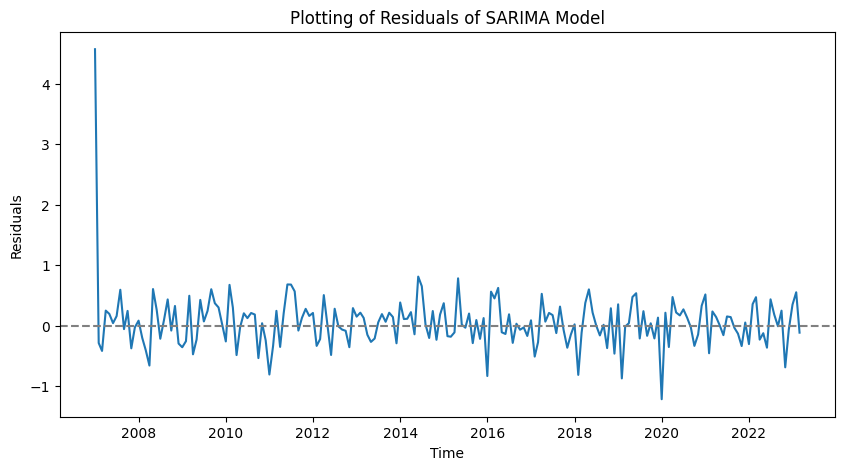

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(SARIMA_resid)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Plotting of Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

In [150]:
values = SARIMA_resid.values.reshape(-1, 1)

# Use the previous 12 months to predict the next month
look_back = 12
X, y = create_dataset(values, look_back)

# Split the data into training and testing sets
train_end_index = SARIMA_resid.index.get_loc('2022-01-01')
test_start_index = SARIMA_resid.index.get_loc('2022-01-01')

trainX, testX = X[:train_end_index - look_back], X[train_end_index - look_back:test_start_index + len(SARIMA_resid.loc['2022-01':'2023-03'])]
trainY, testY = y[:train_end_index - look_back], y[train_end_index - look_back:test_start_index + len(SARIMA_resid.loc['2022-01':'2023-03'])]

In [164]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model and the set of hyperparameters to be evaluated
mlp = MLPRegressor(max_iter = 1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100, 50), (100, 100), (150, 150)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Adding regularization
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'tanh']
}

scorer = make_scorer(rmse_scorer, greater_is_better=False)

# Perform grid search with cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring=scorer, cv=tscv)
grid_search.fit(trainX, trainY)

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score: {grid_search.best_score_}')

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150), 'solver': 'sgd'}
Best score: -0.34218771506883544


In [165]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = -results['mean_test_score']
results['std_test_rmse'] = results['std_test_score']

# Get the top 5 models
top5_results = results.nsmallest(5, 'mean_test_rmse')

# Print the best parameters found
print(f'Best parameters found: {grid_search.best_params_}')

# Print the best score achieved
print(f'Best score (RMSE on original scale): {grid_search.best_score_}')

# Create DataFrame with top 5 models
top5_df = top5_results[['param_hidden_layer_sizes', 'param_alpha', 'param_solver', 'param_activation', 'mean_test_rmse', 'std_test_rmse']]
top5_df = top5_df.rename(columns={
    'param_hidden_layer_sizes': 'Hidden Layer Sizes',
    'param_alpha': 'Alpha',
    'param_max_iter': 'Max Iter',
    'param_solver': 'Solver',
    'param_activation': 'Activation',
    'mean_test_rmse': 'Mean Test RMSE',
    'std_test_rmse': 'Std Test RMSE'
})

# Show the top 5 models DataFrame
top5_df

Best parameters found: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (150, 150), 'solver': 'sgd'}
Best score (RMSE on original scale): -0.34218771506883544


,Hidden Layer Sizes,Alpha,Solver,Activation,Mean Test RMSE,Std Test RMSE
23,"(150, 150)",0.1,sgd,relu,0.342188,0.037562
17,"(150, 150)",0.01,sgd,relu,0.343135,0.037993
11,"(150, 150)",0.001,sgd,relu,0.343140,0.037992
5,"(150, 150)",0.0001,sgd,relu,0.343141,0.037992
19,"(100, 50)",0.1,sgd,relu,0.345669,0.026687


In [166]:
# Train the model with the best hyperparameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(trainX, trainY)

# Make predictions
trainPredict = best_mlp.predict(trainX)
testPredict = best_mlp.predict(testX)

# Inverse predictions
trainPredict = trainPredict.reshape(-1, 1)
testPredict = testPredict.reshape(-1, 1)

In [167]:
index_dates = pd.date_range(start='2022-01-01', periods=len(testPredict), freq='MS') 

In [168]:
testPredict_df = pd.DataFrame(testPredict, columns=['Predictions'], index=index_dates)

In [169]:
testPredict_df

,Predictions
2022-01-01,-0.079159
2022-02-01,0.028874
2022-03-01,-0.025479
2022-04-01,-0.079995
2022-05-01,-0.086728
2022-06-01,0.003573
2022-07-01,0.029117
2022-08-01,0.004220
2022-09-01,0.029055
2022-10-01,0.001895


In [170]:
SARIMA_pred_test

2022-01-01    5601.273964
2022-02-01    4709.190388
2022-03-01    4799.428938
2022-04-01    5346.434572
2022-05-01    6208.804438
2022-06-01    7149.489970
2022-07-01    8031.459498
2022-08-01    8880.041271
2022-09-01    8807.007272
2022-10-01    8440.753341
2022-11-01    7704.811147
2022-12-01    7650.161182
2023-01-01    7094.632212
2023-02-01    6115.101663
2023-03-01    6297.684398
Freq: MS, Name: predicted_mean, dtype: float64

In [171]:
test['generation_value']

date
2022-01-01    4738.960944
2022-02-01    4613.552929
2022-03-01    5472.258523
2022-04-01    5096.418726
2022-05-01    5982.577401
2022-06-01    5924.103086
2022-07-01    8348.661311
2022-08-01    9334.555921
2022-09-01    9235.083571
2022-10-01    9718.336632
2022-11-01    6211.097222
2022-12-01    6538.296374
2023-01-01    6494.718977
2023-02-01    6690.821532
2023-03-01    6258.100081
Name: generation_value, dtype: float64

In [172]:
start_weight = -5000
end_weight = 5000
step = 1

best_rmse = np.inf 
best_weight = None

# Loop for possible weights
for weight in np.arange(start_weight, end_weight + step, step):
    # Calculate combined predictions
    combined_predictions = SARIMA_pred_test + weight * testPredict_df['Predictions']

    # Calculate RMSE
    current_rmse = rmse_scorer(test['generation_value'], combined_predictions)

    # Verify best weight
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_weight = weight

SARIMA_MLP_RMSE = best_rmse

print(f"Best Weight: {best_weight}")
print(f"Best RMSE: {best_rmse}")

Best Weight: -1486
Best RMSE: 774.1821816198301


In [173]:
# Make future predictions from April 2023 to June 2024
future_steps = 15  # Number of months from April 2023 to June 2024
last_window = values[-look_back:].reshape(1, -1)

future_predictions_resid = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions_resid.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions_resid = np.array(future_predictions_resid).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2023-04-01', periods=future_steps, freq='MS')
future_df_resid = pd.DataFrame(data=future_predictions_resid, index=future_dates, columns=['generation_value'])

future_df_resid

,generation_value
2023-04-01,0.027311
2023-05-01,-0.036264
2023-06-01,-0.002630
2023-07-01,0.010595
2023-08-01,0.112421
2023-09-01,0.053377
2023-10-01,-0.072690
2023-11-01,0.037258
2023-12-01,0.030125
2024-01-01,-0.045934


In [174]:
combined_predictions = predictions_future_inv['Forecast'] + best_weight * future_df_resid['generation_value']

combined_predictions

2023-04-01     6807.826054
2023-05-01     7915.058139
2023-06-01     8450.306973
2023-07-01    10032.534654
2023-08-01    11097.576076
2023-09-01    10876.587225
2023-10-01    10793.661794
2023-11-01     8847.941531
2023-12-01     8813.859592
2024-01-01     8016.098081
2024-02-01     7315.688525
2024-03-01     7280.182615
2024-04-01     7696.509898
2024-05-01     8830.990515
2024-06-01     9608.200822
Freq: MS, dtype: float64

RMSE for SARIMA-MLP model: 1296.0628268816838


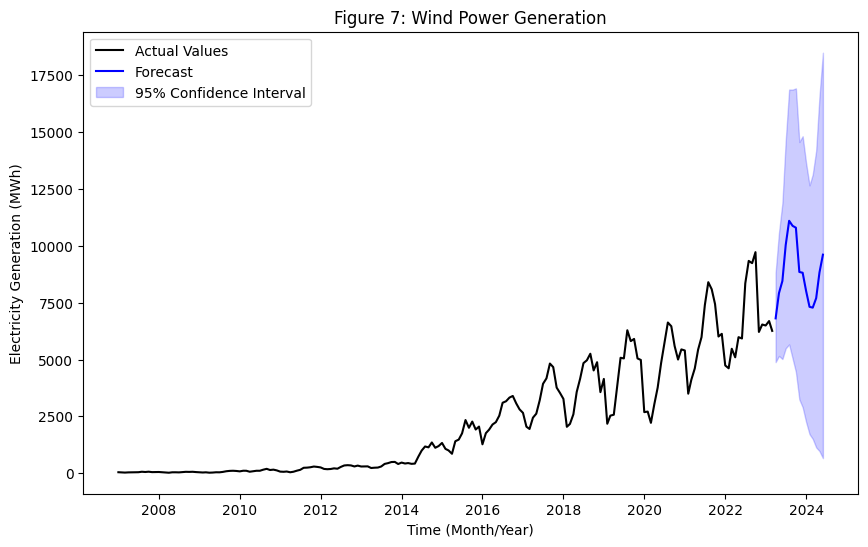

In [175]:
# Compare future predictions with validation data and calculate RMSE
validation_actuals = df_validation['generation_value']
SARIMA_MLP_RMSE = np.sqrt(mean_squared_error(validation_actuals, combined_predictions.squeeze()))
print(f'RMSE for SARIMA-MLP model: {SARIMA_MLP_RMSE}')

# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_train_valid.index, df_inv, color='black', label='Actual Values')
plt.plot(combined_predictions.index, combined_predictions, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()

In [178]:
data = {
    "Model": ["SARIMA", "MLP", "SARIMA-MLP"],
    "RMSE": [SARIMA_RMSE, MLP_RMSE, SARIMA_MLP_RMSE]
}

rmse_df = pd.DataFrame(data)
rmse_df

,Model,RMSE
0,SARIMA,1305.383021
1,MLP,2691.631058
2,SARIMA-MLP,1296.062827


# Future Predictions

In [192]:
df_total['generation_value_boxcox'], fitted_lambda = boxcox(df_total['generation_value'])

# Fit the chosen SARIMA model
arima_order = (4, 0, 4)
seasonal_order = (1, 0, 2, 12)

model = SARIMAX(df_total['generation_value_boxcox'], order=arima_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecasting
steps = 18 # Number of steps for forecasting based on test dataset length
predictions_future = model_fit.forecast(steps=steps)
predictions_future_inv = inv_boxcox(predictions_future, fitted_lambda)
df_inv = inv_boxcox(df_total['generation_value_boxcox'], fitted_lambda)

# Obtain forecasts with confidence intervals
forecast_results = model_fit.get_forecast(steps=steps)
conf_int = forecast_results.conf_int(alpha=0.05)

# Convert the lower and upper bounds back from Box-Cox
conf_int_inv = inv_boxcox(conf_int, fitted_lambda)

# Calculating standard deviations
std_errors = (conf_int_inv.iloc[:, 1] - conf_int_inv.iloc[:, 0]) / (2 * 1.96)

# Generate dates for the forecast period from 2023-04 to 2024-06
last_date = df_total.index[-1]
dates_forecast = pd.date_range(start=last_date, periods=steps+1, freq='M')[1:]

# Convert predictions_future_inv to DataFrame
predictions_future_inv = predictions_future_inv.to_frame(name='Forecast')

# Ensure std_errors is in a DataFrame
std_errors_df = pd.DataFrame(std_errors, index=predictions_future_inv.index, columns=['std_err'])

# Build the forecast_df DataFrame with forecasts and standard errors
forecast_df = pd.concat([predictions_future_inv, std_errors_df], axis=1)

# Calculating the 95% confidence interval
lower_bound = forecast_df['Forecast'] - 1.96 * forecast_df['std_err']
upper_bound = forecast_df['Forecast'] + 1.96 * forecast_df['std_err']

# Calculate the resid

SARIMA_resid_future = model_fit.resid

SARIMA_pred_future = predictions_future_inv

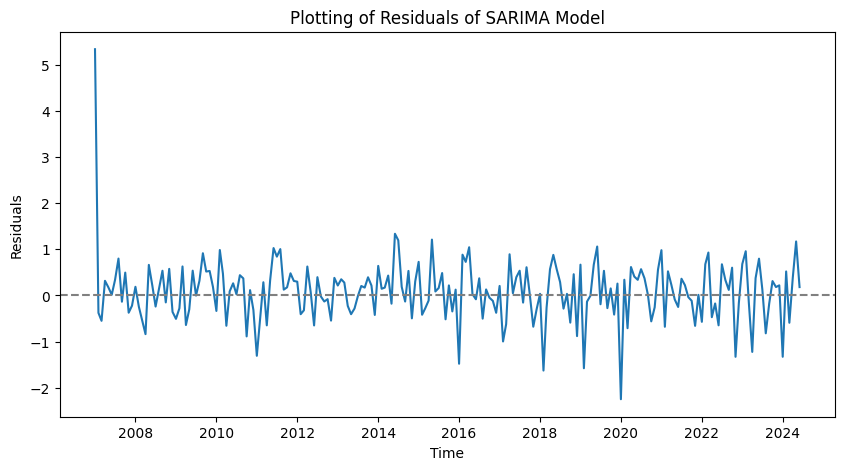

In [193]:
plt.figure(figsize=(10, 5))
plt.plot(SARIMA_resid_future)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Plotting of Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

In [194]:
SARIMA_pred_future

,Forecast
2024-07-01,11116.940724
2024-08-01,11351.938221
2024-09-01,11389.942959
2024-10-01,11363.271919
2024-11-01,9320.532960
2024-12-01,9498.715949
2025-01-01,7876.887464
2025-02-01,7536.528621
2025-03-01,7303.744558
2025-04-01,7417.846211


In [195]:
values = SARIMA_resid_future.values.reshape(-1, 1)

# Make future predictions from July 2024 to December 2025
future_steps = 18  # Number of months from July 2024 to December 2025
last_window = values[-look_back:].reshape(1, -1)

future_predictions_resid = []
for _ in range(future_steps):
    next_prediction = best_mlp.predict(last_window)
    future_predictions_resid.append(next_prediction[0])
    last_window = np.append(last_window[:, 1:], next_prediction).reshape(1, -1)

future_predictions_resid = np.array(future_predictions_resid).reshape(-1, 1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start='2024-07-01', periods=future_steps, freq='MS')
future_df_resid = pd.DataFrame(data=future_predictions_resid, index=future_dates, columns=['generation_value'])

future_df_resid

,generation_value
2024-07-01,-0.070999
2024-08-01,0.053070
2024-09-01,0.210285
2024-10-01,-0.023599
2024-11-01,0.164546
2024-12-01,0.065753
2025-01-01,0.053733
2025-02-01,0.006988
2025-03-01,0.048149
2025-04-01,0.008880


In [196]:
combined_predictions = SARIMA_pred_future['Forecast'] + best_weight * future_df_resid['generation_value']

combined_predictions

2024-07-01    11222.445979
2024-08-01    11273.076665
2024-09-01    11077.458763
2024-10-01    11398.339700
2024-11-01     9076.017832
2024-12-01     9401.006398
2025-01-01     7797.040669
2025-02-01     7526.144087
2025-03-01     7232.194653
2025-04-01     7404.649943
2025-05-01     9479.476358
2025-06-01    10420.324642
2025-07-01    11850.275604
2025-08-01    12175.974684
2025-09-01    12186.263402
2025-10-01    12076.413647
2025-11-01    10079.036513
2025-12-01    10208.062074
Freq: MS, dtype: float64

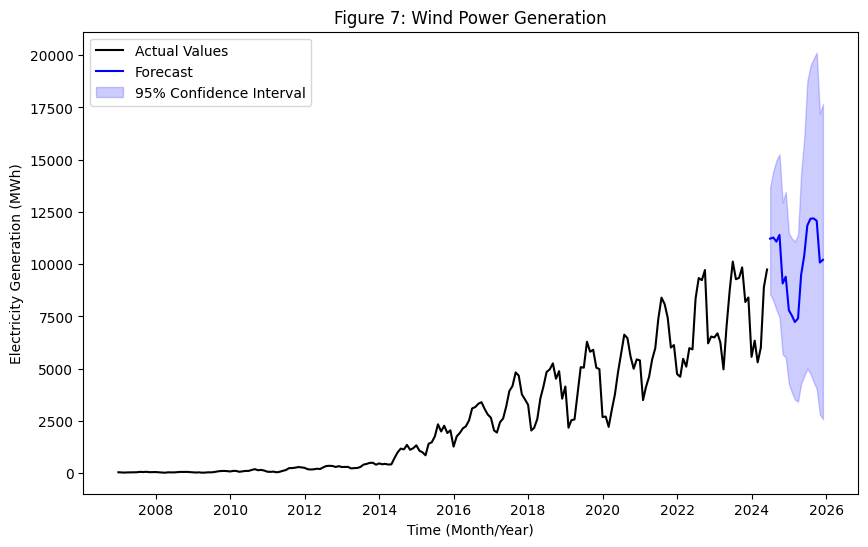

In [197]:
# Plot of actual, fitted, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_total.index, df_inv, color='black', label='Actual Values')
plt.plot(combined_predictions.index, combined_predictions, color='blue', label='Forecast')
plt.fill_between(forecast_df.index, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Figure 7: Wind Power Generation')
plt.xlabel('Time (Month/Year)')
plt.ylabel('Electricity Generation (MWh)')
plt.show()